# Разведочный анализ данных

## Описание

Основная задача проекта – выявить ключевые темы обсуждений у 18 активных чатов и каналов выпускных сообществ Яндекс Практикума, определить, какие из них наиболее интересны аудитории, и на основе этого формировать информативные дайджесты для выпускников.

**Контекст**

- необходимо провести первичный анализ сообщений,

**Что нужно сделать?**

1. кто пишет часто
2. в какое время чаще всего пишут пользователи
3. сколько пишут сообщений сколько
4. анализ времени → пики активности, дни недели.
5. подумать, что можно еще посчитать полезного
6. какие темы обсуждали
7. какие слова использовали
8. какое настроение

**Результат:**

- код .py, .ipynb
- csv/xlsx файл со статистикой

## Библиотеки

In [84]:
import logging
import os
import warnings
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import networkx as nx
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import mstats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import ast
from wordcloud import WordCloud
from collections import Counter


# Настройка параметров matplotlib
mpl.rcParams.update(mpl.rcParamsDefault)

# Настройка логирования
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Игнорирование предупреждений
warnings.filterwarnings('ignore')

# Настройка стиля seaborn
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")

# Включение отображения графиков в Jupyter Notebook
%matplotlib inline

## Загрузка датасетов

In [85]:
manage_alumin = pd.read_csv('.\datasets\MANAGEMENT ALUMNI PRACTICUM.csv')
data_practicum = pd.read_csv('.\datasets\Data Practicum Chat.csv')
marketing_chat = pd.read_csv('.\datasets\Marketing Practicum Chat.csv')


print('Загрузка MANAGEMENT ALUMNI PRACTICUM:', manage_alumin.shape, 'загрузка Data Practicum Chat:', 
data_practicum.shape, 'загрузка Marketing Practicum Chat:', marketing_chat.shape)

Загрузка MANAGEMENT ALUMNI PRACTICUM: (13, 18) загрузка Data Practicum Chat: (1007, 36) загрузка Marketing Practicum Chat: (3680, 31)


# ==============================================
# БЛОК 1: ПОДГОТОВКА ДАННЫХ
# ==============================================

In [86]:

def preprocess_df(df):
    """Предобработка данных"""
    # Преобразование даты
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
    
    # Обработка текста
    if 'text' in df.columns:
        try:
            # Пробуем преобразовать из JSON строки
            import ast
            df['text'] = df['text'].apply(ast.literal_eval)
            df['text_clean'] = df['text'].apply(lambda x: x[0]['text'] if x else '')
        except:
            # Если не получается, оставляем как есть
            df['text_clean'] = df['text'].fillna('')
    
    # Добавляем временные метрики
    df['hour'] = df['date'].dt.hour
    df['day_of_week'] = df['date'].dt.day_name()
    df['date_only'] = df['date'].dt.date
    
    return df



print("Предобработка данных...")
manage_alumin = preprocess_df(manage_alumin)
data_practicum = preprocess_df(data_practicum)
marketing_chat = preprocess_df(marketing_chat)

Предобработка данных...


# ==============================================
# БЛОК 2: АНАЛИЗ АКТИВНЫХ ПОЛЬЗОВАТЕЛЕЙ
# ==============================================



АНАЛИЗ АКТИВНЫХ ПОЛЬЗОВАТЕЛЕЙ

Анализ активных пользователей в MANAGEMENT ALUMNI:


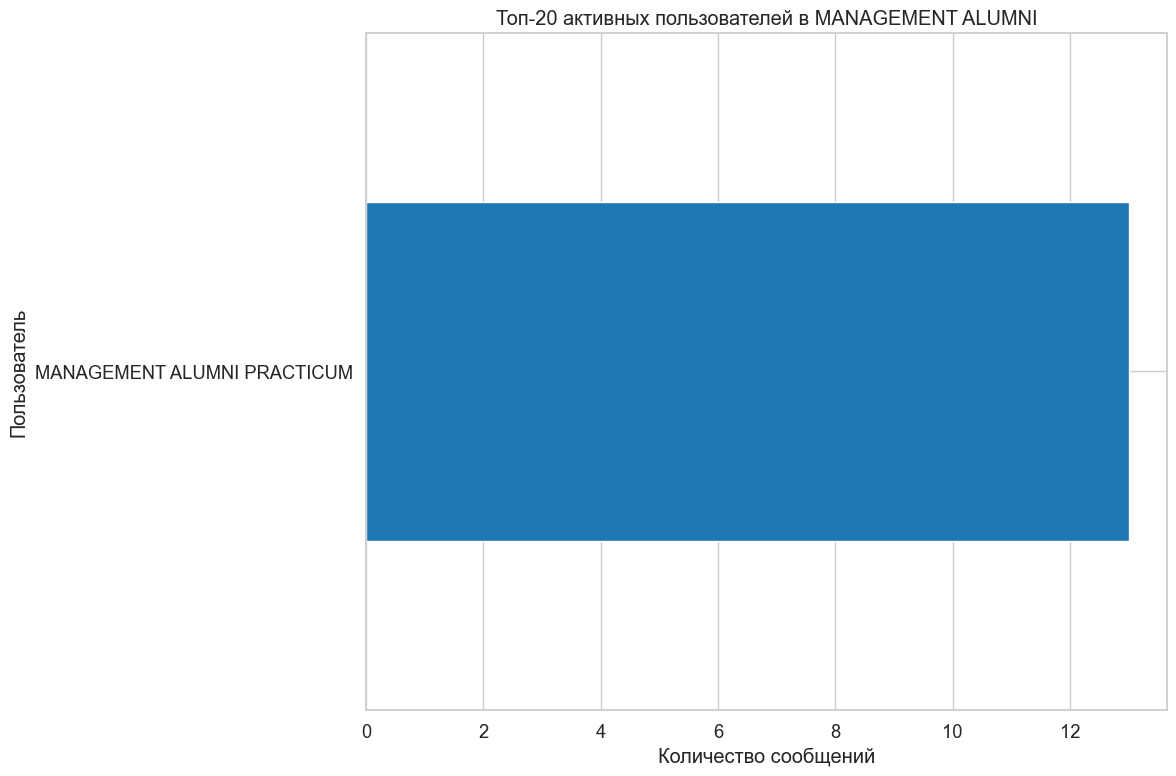


Анализ активных пользователей в DATA PRACTICUM:


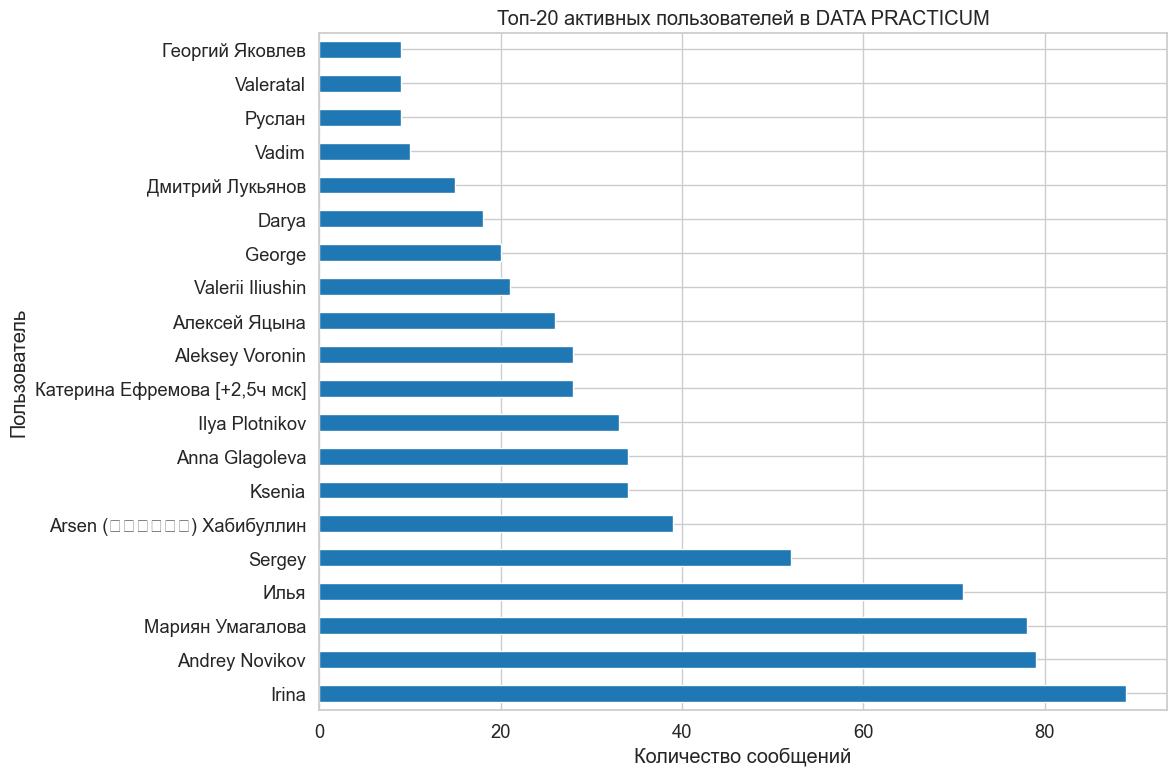


Анализ активных пользователей в MARKETING CHAT:


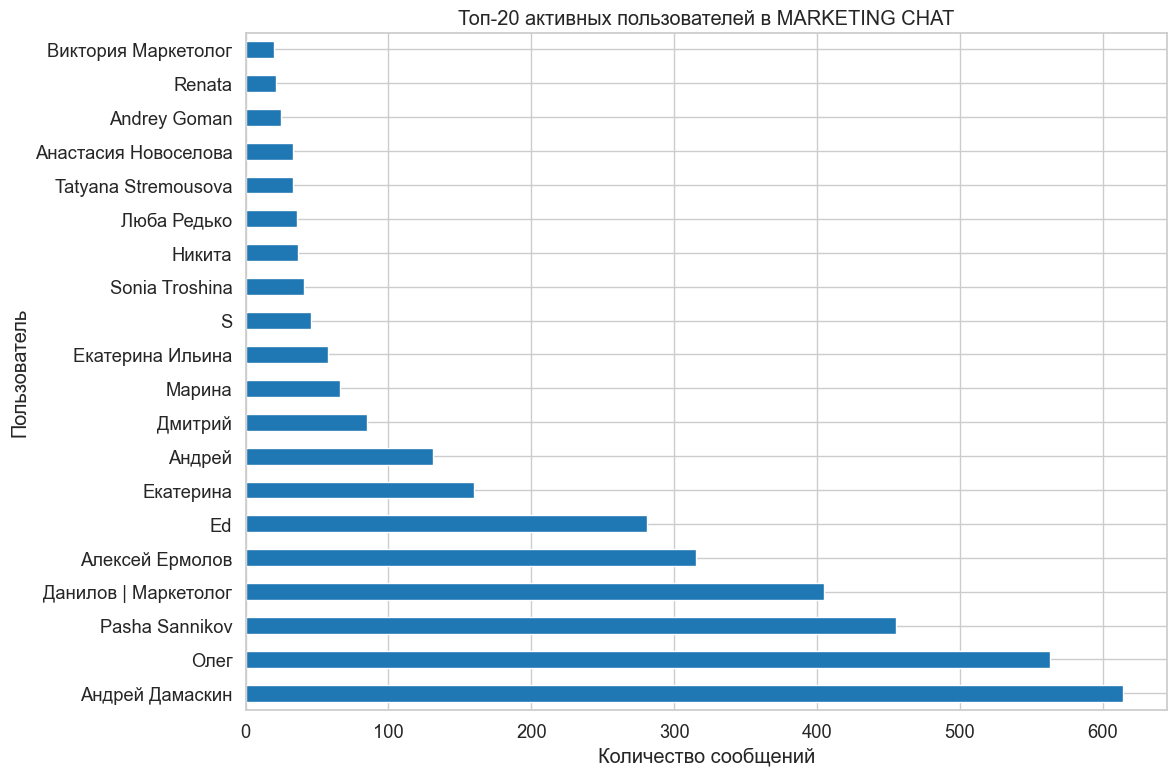

In [87]:

def analyze_active_users(df, chat_name):
    """Анализ самых активных пользователей"""
    print(f"\nАнализ активных пользователей в {chat_name}:")
    
    # Топ-20 пользователей по количеству сообщений
    user_activity = df['from'].value_counts().head(20)
    
    # Визуализация
    plt.figure(figsize=(12, 8))
    user_activity.plot(kind='barh')
    plt.title(f'Топ-20 активных пользователей в {chat_name}')
    plt.xlabel('Количество сообщений')
    plt.ylabel('Пользователь')
    plt.tight_layout()
    plt.show()
    
    return user_activity

print("\n" + "="*50)
print("АНАЛИЗ АКТИВНЫХ ПОЛЬЗОВАТЕЛЕЙ")
print("="*50)

active_users_manage = analyze_active_users(manage_alumin, "MANAGEMENT ALUMNI")
active_users_data = analyze_active_users(data_practicum, "DATA PRACTICUM")
active_users_marketing = analyze_active_users(marketing_chat, "MARKETING CHAT")

# ==============================================
# БЛОК 3: АНАЛИЗ ВРЕМЕННЫХ ПАТТЕРНОВ
# ==============================================



АНАЛИЗ ВРЕМЕННЫХ ПАТТЕРНОВ

Анализ временных паттернов в MANAGEMENT ALUMNI:


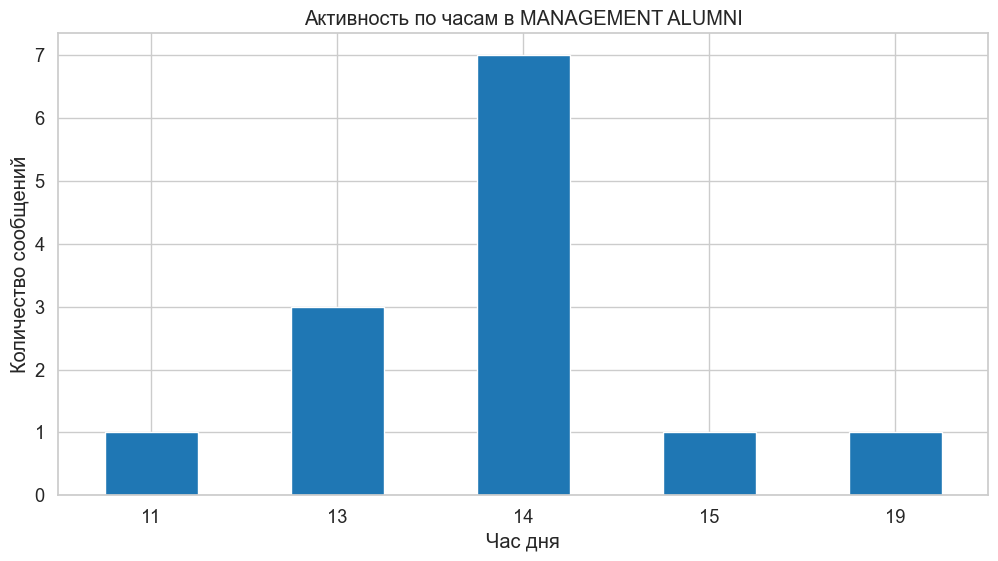

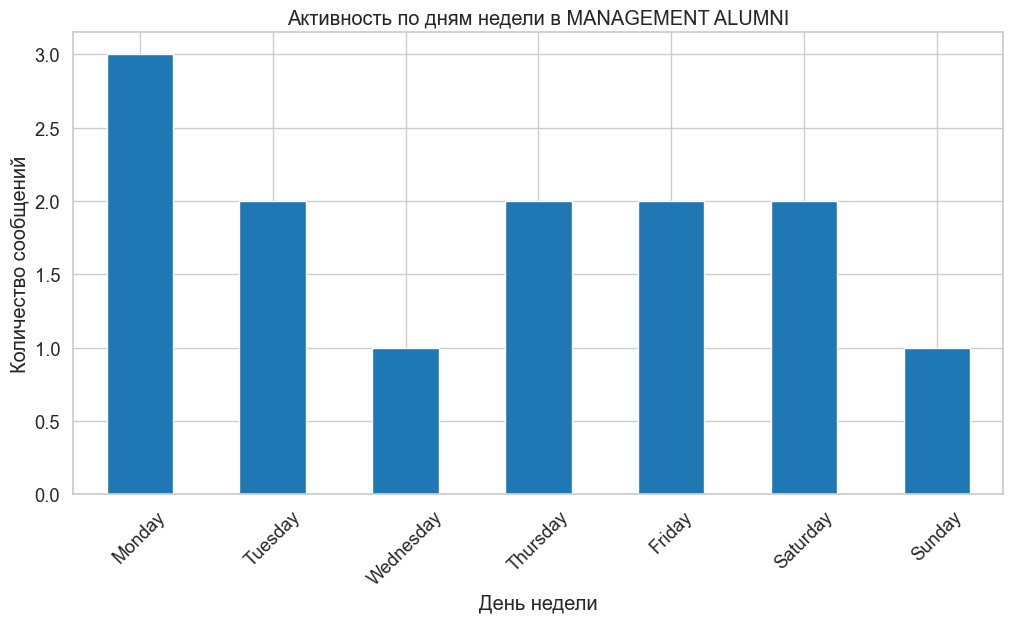

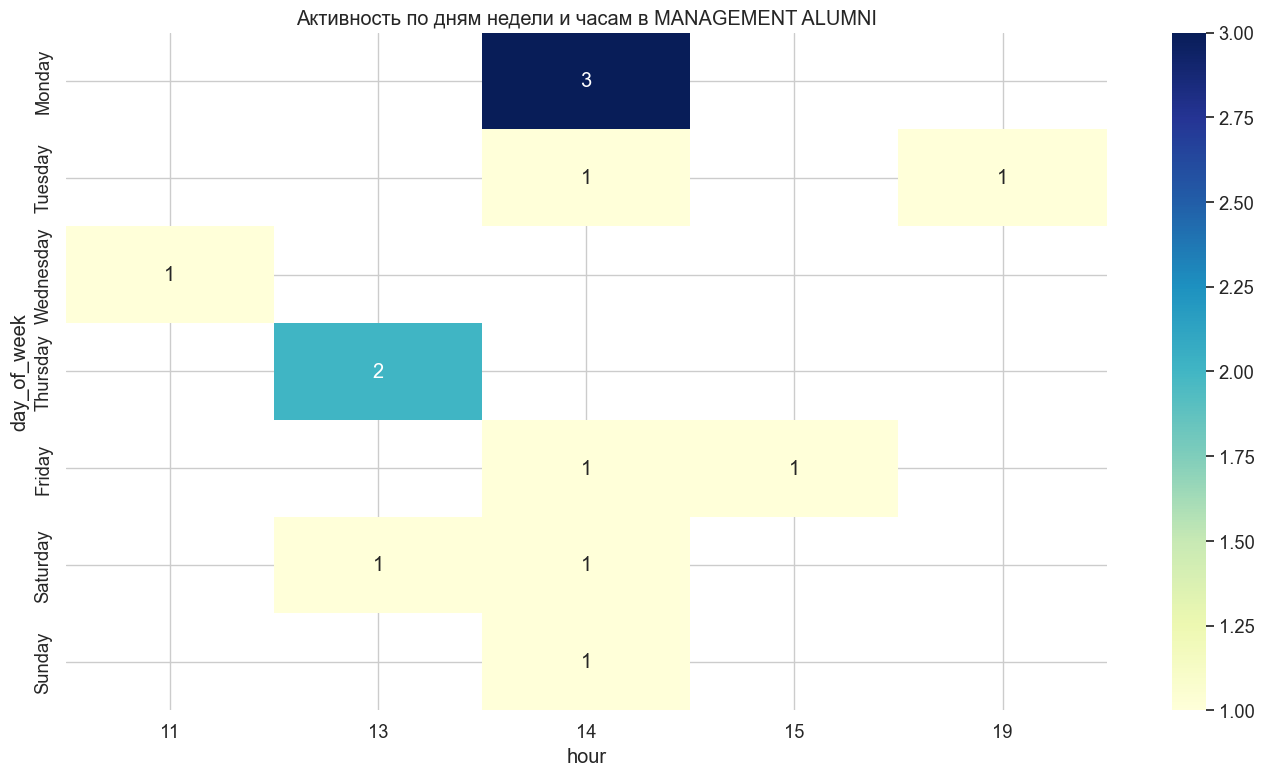


Анализ временных паттернов в DATA PRACTICUM:


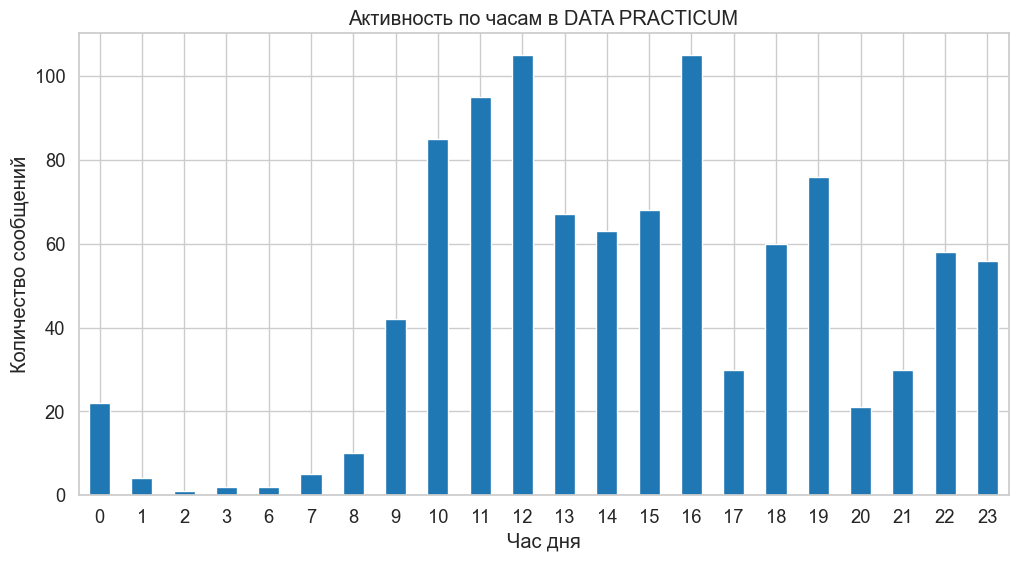

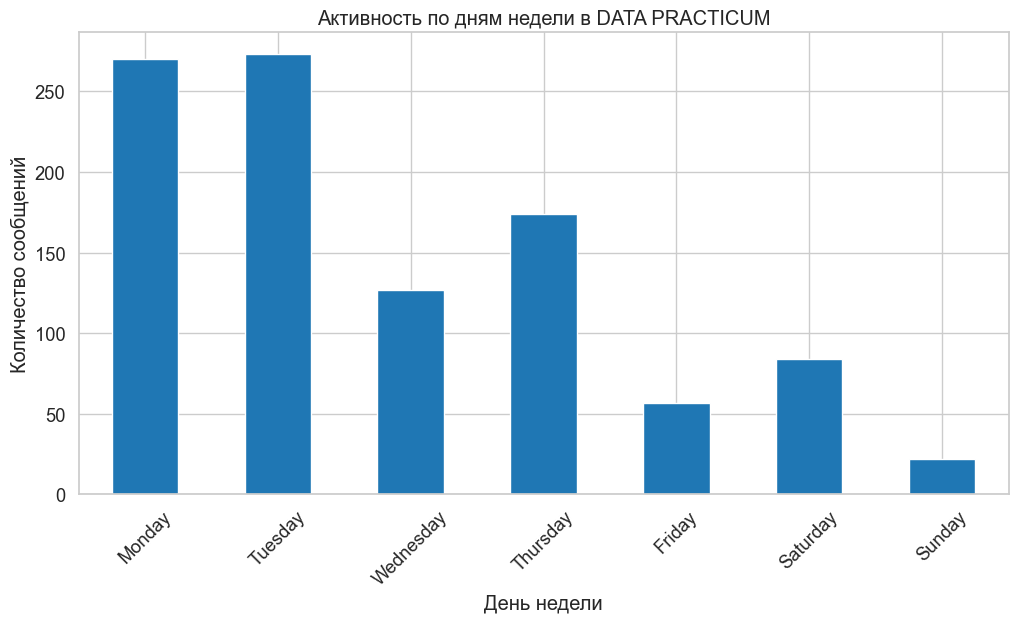

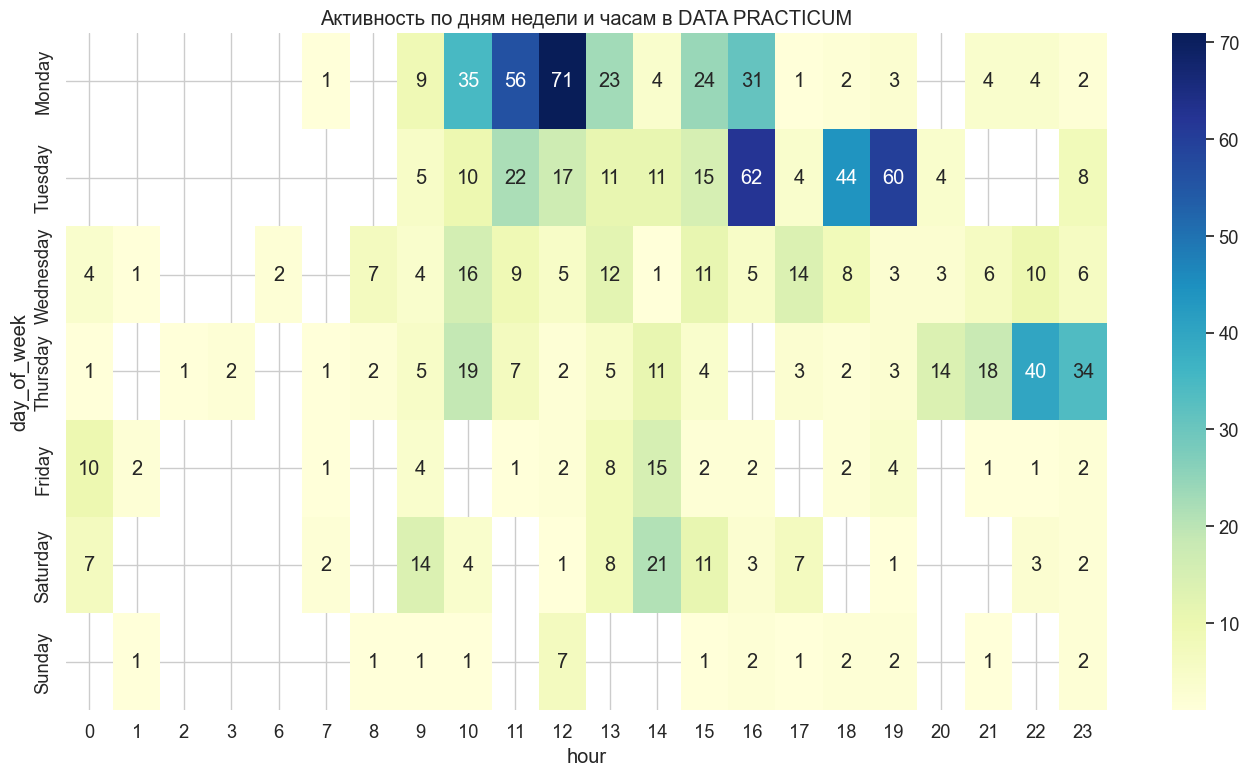


Анализ временных паттернов в MARKETING CHAT:


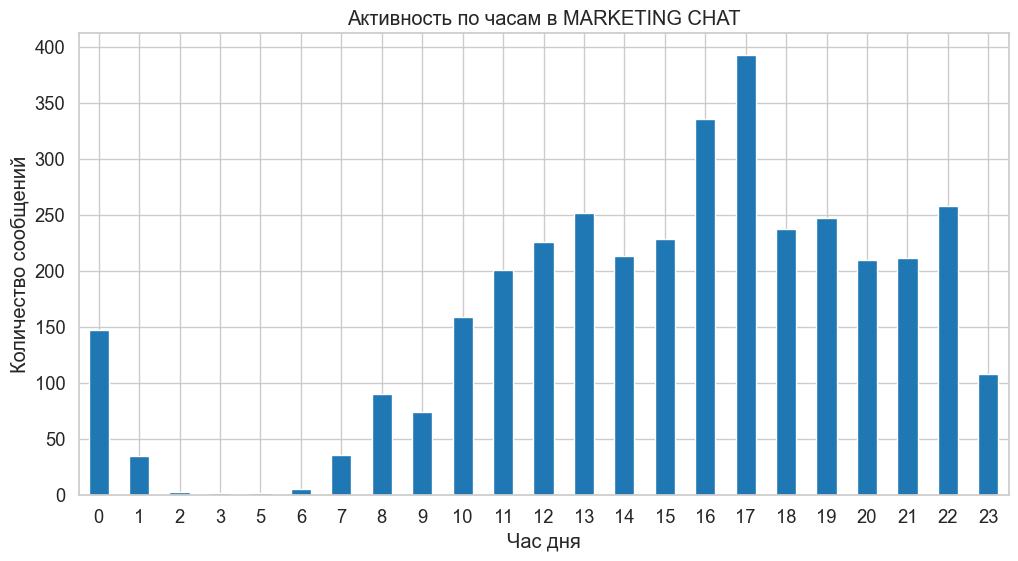

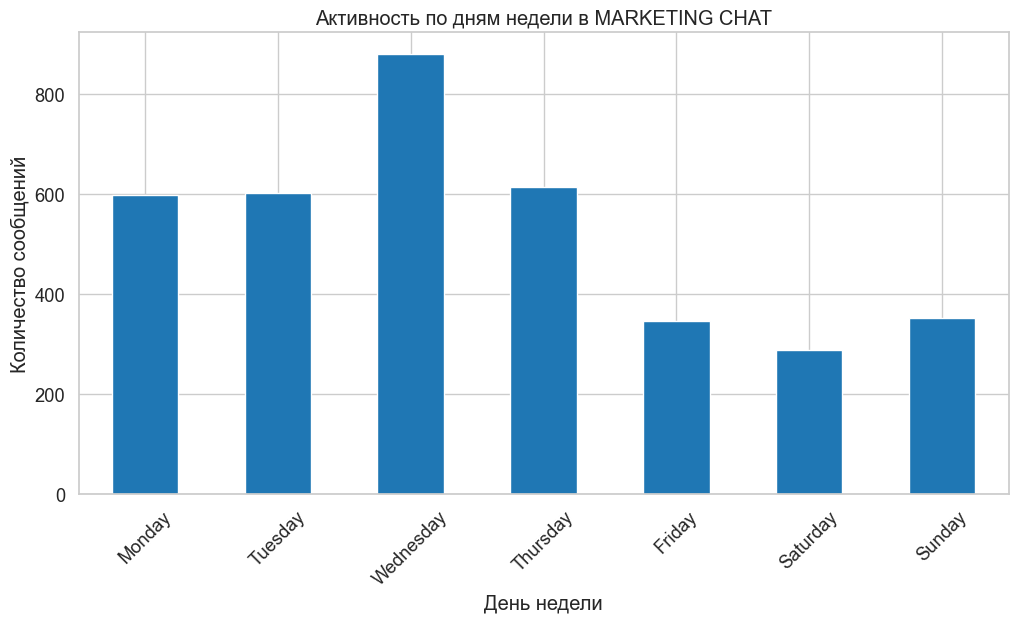

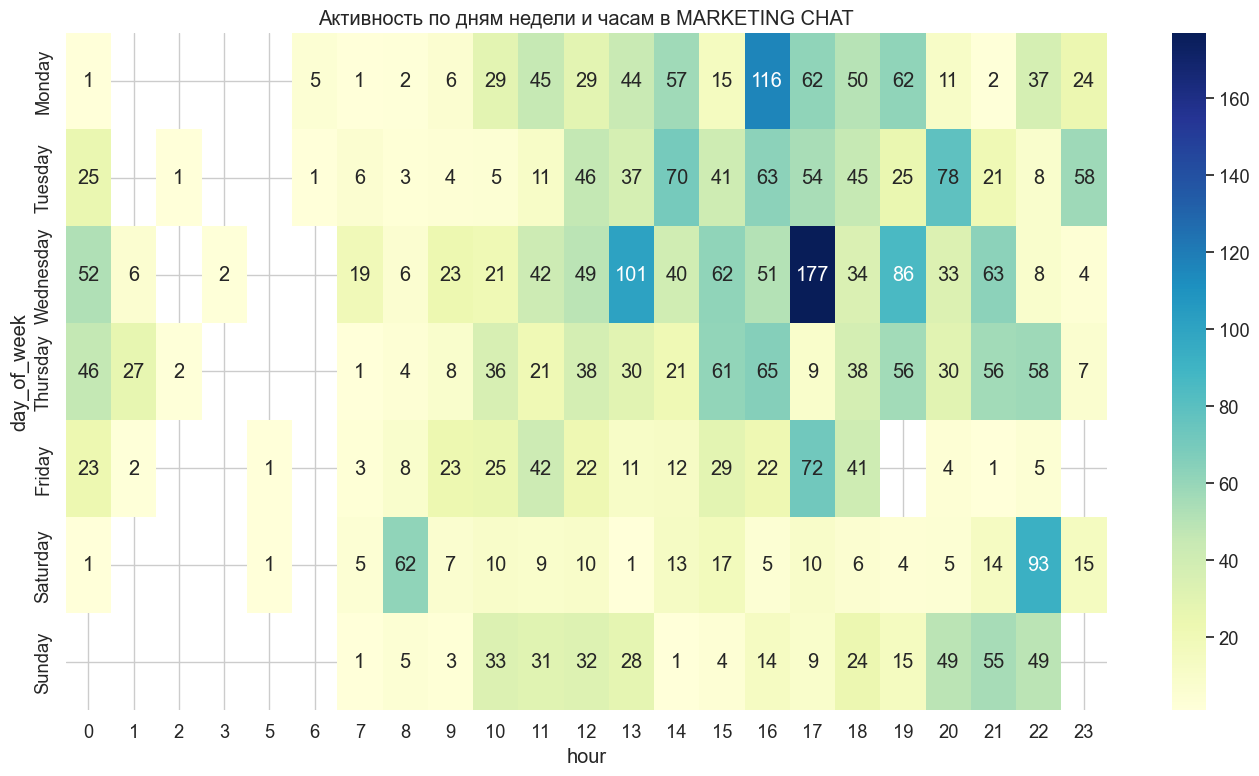

In [88]:

def analyze_time_patterns(df, chat_name):
    """Анализ активности по времени"""
    print(f"\nАнализ временных паттернов в {chat_name}:")
    
    # Активность по часам
    hourly_activity = df['hour'].value_counts().sort_index()
    
    plt.figure(figsize=(12, 6))
    hourly_activity.plot(kind='bar')
    plt.title(f'Активность по часам в {chat_name}')
    plt.xlabel('Час дня')
    plt.ylabel('Количество сообщений')
    plt.xticks(rotation=0)
    plt.show()
    
    # Активность по дням недели
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_activity = df['day_of_week'].value_counts().reindex(days_order)
    
    plt.figure(figsize=(12, 6))
    daily_activity.plot(kind='bar')
    plt.title(f'Активность по дням недели в {chat_name}')
    plt.xlabel('День недели')
    plt.ylabel('Количество сообщений')
    plt.xticks(rotation=45)
    plt.show()
    
    # Комбинированная heatmap
    heatmap_data = df.groupby(['day_of_week', 'hour']).size().unstack().reindex(days_order)
    plt.figure(figsize=(14, 8))
    sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt="g")
    plt.title(f'Активность по дням недели и часам в {chat_name}')
    plt.tight_layout()
    plt.show()
    
    return {
        'hourly_activity': hourly_activity,
        'daily_activity': daily_activity
    }

print("\n" + "="*50)
print("АНАЛИЗ ВРЕМЕННЫХ ПАТТЕРНОВ")
print("="*50)

time_patterns_manage = analyze_time_patterns(manage_alumin, "MANAGEMENT ALUMNI")
time_patterns_data = analyze_time_patterns(data_practicum, "DATA PRACTICUM")
time_patterns_marketing = analyze_time_patterns(marketing_chat, "MARKETING CHAT")


# ==============================================
# БЛОК 4: АНАЛИЗ ТЕКСТОВОГО СОДЕРЖАНИЯ
# ==============================================


АНАЛИЗ ТЕКСТОВОГО СОДЕРЖАНИЯ

Анализ текстового содержания в MANAGEMENT ALUMNI:


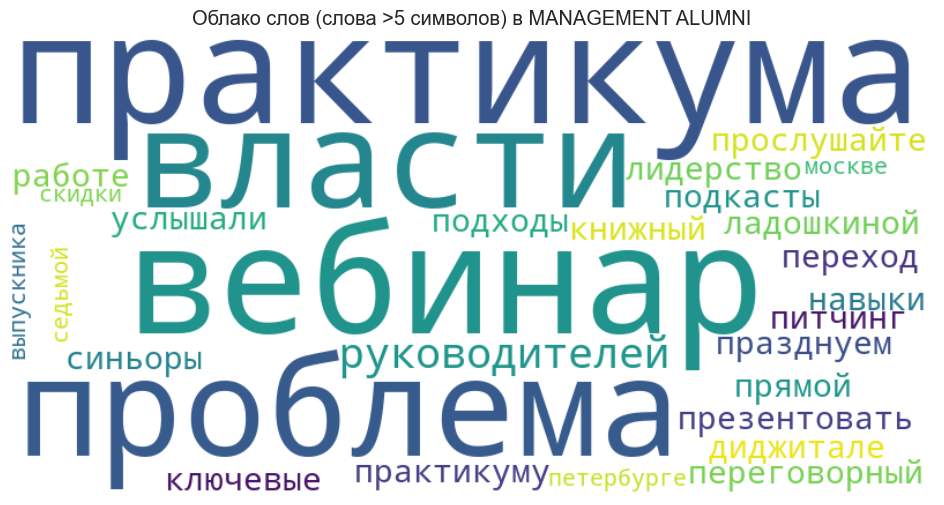

<Figure size 1200x600 with 0 Axes>

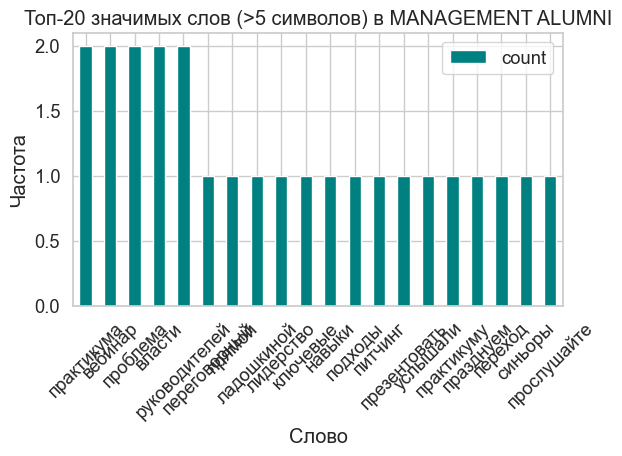


Анализ текстового содержания в DATA PRACTICUM:


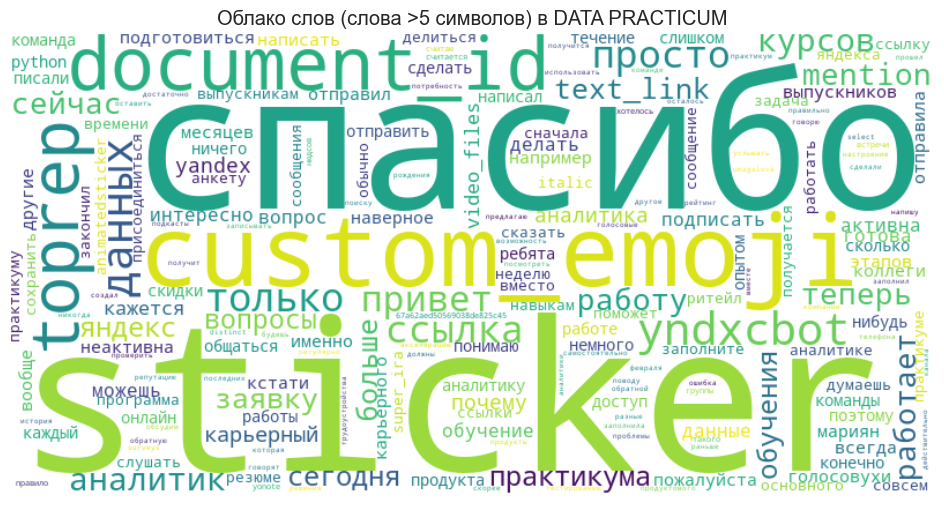

<Figure size 1200x600 with 0 Axes>

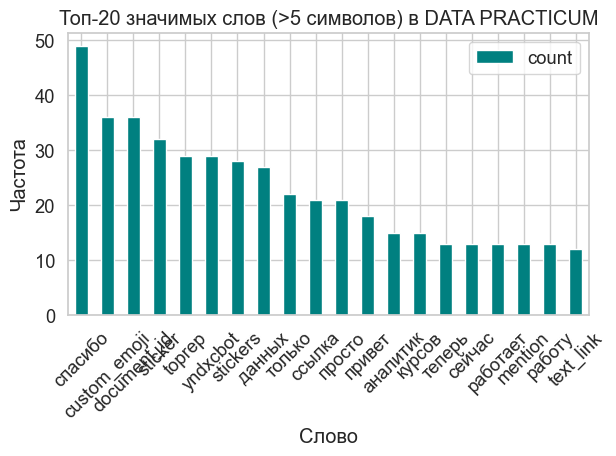


Анализ текстового содержания в MARKETING CHAT:


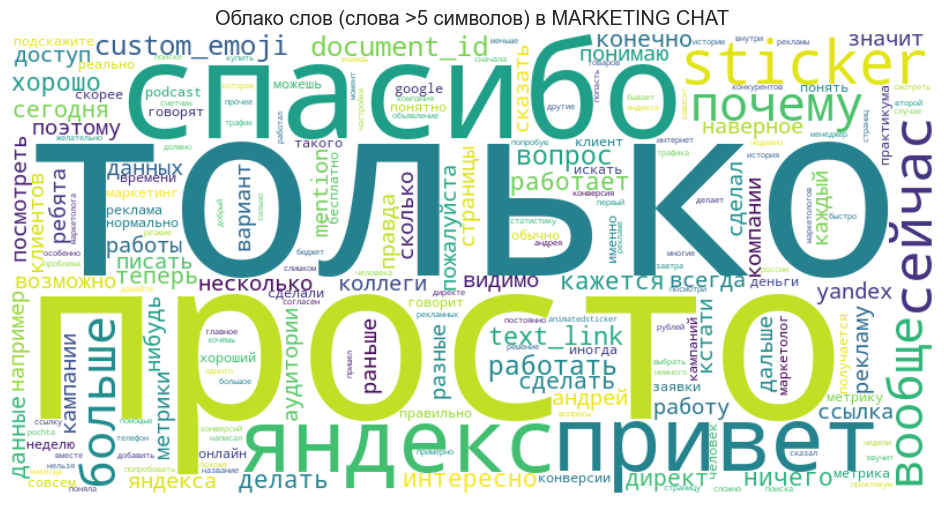

<Figure size 1200x600 with 0 Axes>

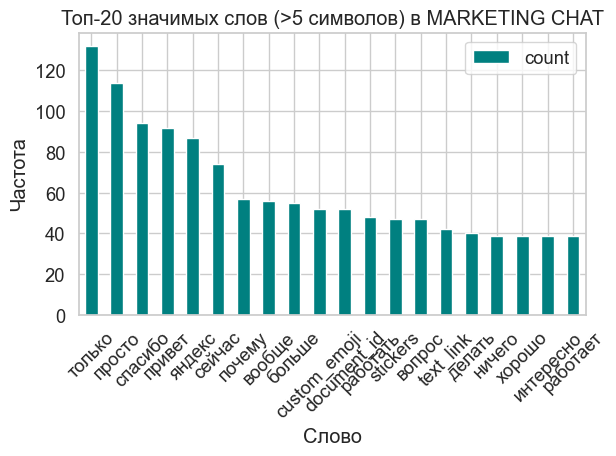

In [89]:
def analyze_text_content(df, chat_name):
    """Анализ текстового содержания"""
    print(f"\nАнализ текстового содержания в {chat_name}:")
    
    if 'text_clean' not in df.columns:
        print("Нет данных для анализа текста")
        return None
    
    # Улучшенная очистка текста
    def clean_text(text):
        if not isinstance(text, str):
            return ''
        
        # Удаляем технические артефакты
        text = re.sub(r'(type|castom_emoji|bot_command|\\n|\[|\]|\{|\}|\(|\))', '', text, flags=re.IGNORECASE)
        
        # Удаляем пунктуацию и спецсимволы (кроме букв и цифр)
        text = re.sub(r'[^\w\s]', ' ', text.lower())
        
        # Удаляем короткие слова и числа
        words = [word for word in text.split() 
                if len(word) > 5  # Берем только слова длиннее 5 символов
                and not word.isdigit()  # Исключаем числа
                and not word.startswith(('http', 'www'))]  # Исключаем ссылки
        
        return ' '.join(words)
    
    df['cleaned_text'] = df['text_clean'].apply(clean_text)
    
    # Дополнительные стоп-слова
    custom_stopwords = {
        'который', 'которые', 'когда', 'потому', 'очень', 'может', 'будет',
        'этого', 'этот', 'какой', 'какие', 'такой', 'такие', 'свой', 'свои',
        'ваш', 'ваши', 'наш', 'наши', 'чтобы', 'можно', 'нужно', 'должен'
    }
    
    # Облако слов с исключением стоп-слов
    all_text = ' '.join(df['cleaned_text'].dropna())
    
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        stopwords=custom_stopwords,
        collocations=False
    ).generate(all_text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Облако слов (слова >5 символов) в {chat_name}')
    plt.axis('off')
    plt.show()
    
    # Топ-20 слов (исключая стоп-слова)
    words = [
        word for text in df['cleaned_text'].dropna() 
        for word in text.split() 
        if word not in custom_stopwords
    ]
    
    word_counts = Counter(words).most_common(20)
    
    if word_counts:
        plt.figure(figsize=(12, 6))
        pd.DataFrame(word_counts, columns=['word', 'count']).plot(
            x='word', y='count', kind='bar', color='teal')
        plt.title(f'Топ-20 значимых слов (>5 символов) в {chat_name}')
        plt.xlabel('Слово')
        plt.ylabel('Частота')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Не удалось выделить значимые слова после очистки")
    
    return word_counts

print("\n" + "="*50)
print("АНАЛИЗ ТЕКСТОВОГО СОДЕРЖАНИЯ")
print("="*50)

text_analysis_manage = analyze_text_content(manage_alumin, "MANAGEMENT ALUMNI")
text_analysis_data = analyze_text_content(data_practicum, "DATA PRACTICUM")
text_analysis_marketing = analyze_text_content(marketing_chat, "MARKETING CHAT")

# ==============================================
# БЛОК 5: СЕТЕВОЙ АНАЛИЗ
# ==============================================


СЕТЕВОЙ АНАЛИЗ

Сетевой анализ в MANAGEMENT ALUMNI:
Нет данных для сетевого анализа

Сетевой анализ в DATA PRACTICUM:


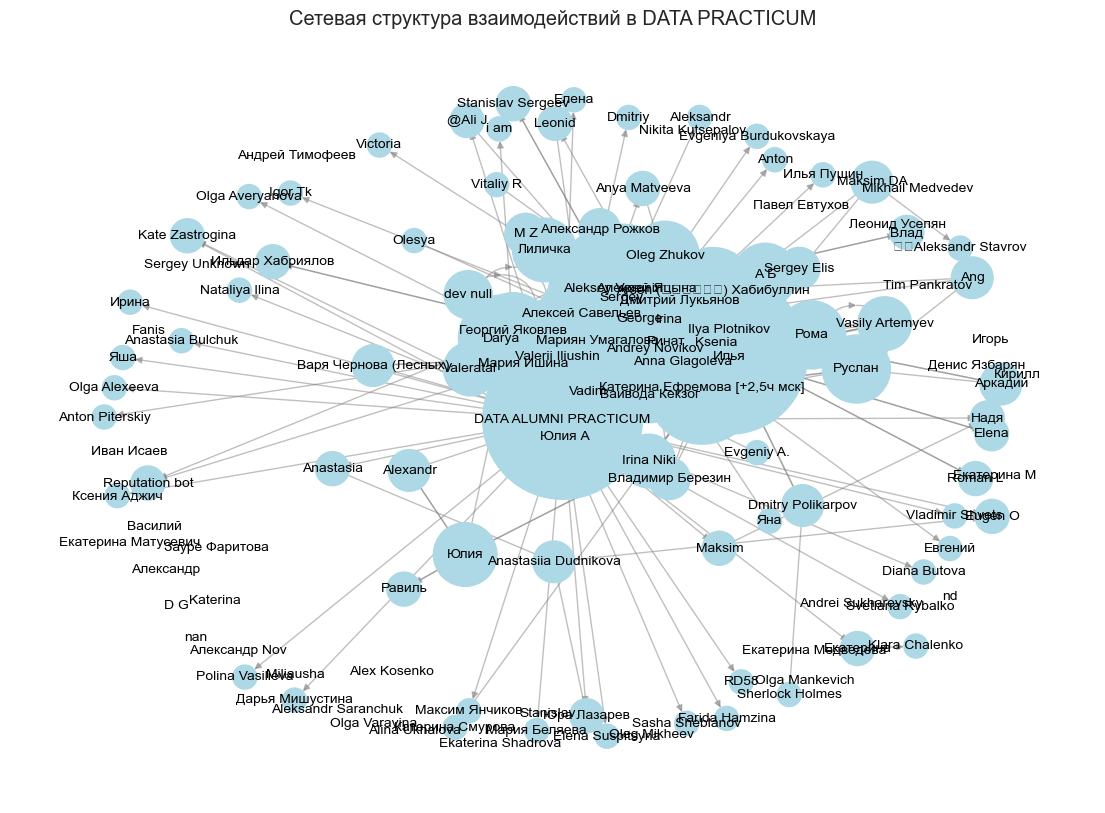


Топ-10 пользователей по центральности:
                             user  degree_centrality  betweenness_centrality
13          DATA ALUMNI PRACTICUM           0.335878                0.000000
2                            Илья           0.320611                0.063520
3                          Sergey           0.282443                0.038371
10               Мариян Умагалова           0.251908                0.023213
43                          Irina           0.206107                0.009455
7                  Andrey Novikov           0.198473                0.012051
47               Valerii Iliushin           0.183206                0.015997
11                         Ksenia           0.175573                0.013866
32                  Алексей Яцына           0.167939                0.013518
44  Катерина Ефремова [+2,5ч мск]           0.167939                0.022019

Сетевой анализ в MARKETING CHAT:


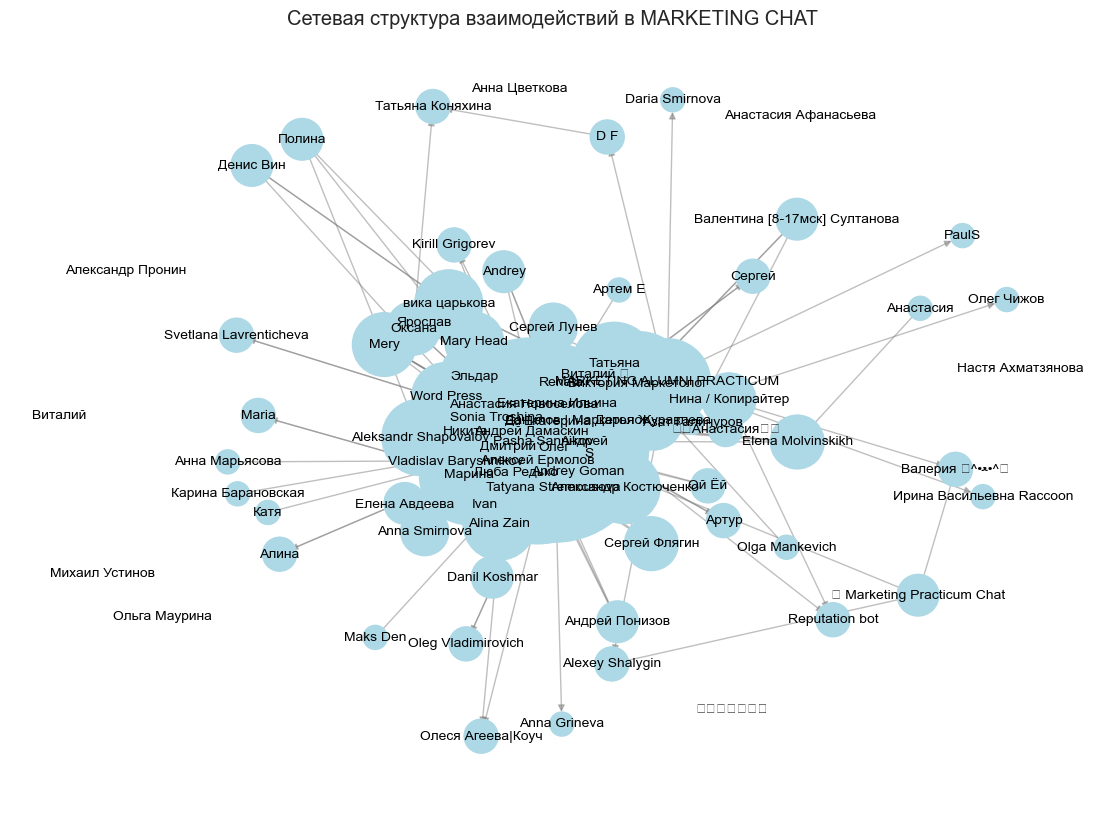


Топ-10 пользователей по центральности:
                    user  degree_centrality  betweenness_centrality
2        Андрей Дамаскин           0.726190                0.115852
7                   Олег           0.726190                0.121152
0         Pasha Sannikov           0.630952                0.115673
13       Алексей Ермолов           0.571429                0.066991
6                     Ed           0.440476                0.059958
1   Данилов | Маркетолог           0.428571                0.041632
67                Андрей           0.357143                0.052851
26             Екатерина           0.309524                0.032061
52      Екатерина Ильина           0.285714                0.015004
9                 Никита           0.285714                0.007073


In [90]:

def analyze_network(df, chat_name):
    """Сетевой анализ взаимодействий"""
    print(f"\nСетевой анализ в {chat_name}:")
    
    if 'reply_to_message_id' not in df.columns or 'from_id' not in df.columns:
        print("Нет данных для сетевого анализа")
        return None
    
    # Создаем граф
    G = nx.DiGraph()
    
    # Добавляем узлы (все пользователи)
    all_users = df['from'].unique()
    for user in all_users:
        G.add_node(user)
    
    # Добавляем ребра (взаимодействия)
    replies = df[df['reply_to_message_id'].notna()]
    if not replies.empty:
        for _, row in replies.iterrows():
            # Находим автора оригинального сообщения
            original_msg = df[df['id'] == row['reply_to_message_id']]
            if not original_msg.empty:
                source = original_msg.iloc[0]['from']
                target = row['from']
                if G.has_edge(source, target):
                    G[source][target]['weight'] += 1
                else:
                    G.add_edge(source, target, weight=1)
    
    # Визуализация графа
    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G, k=0.5)
    
    # Размер узлов зависит от степени (количества связей)
    node_size = [d * 300 for n, d in G.degree()]
    
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=1, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10)
    
    plt.title(f'Сетевая структура взаимодействий в {chat_name}')
    plt.axis('off')
    plt.show()
    
    # Анализ центральности
    if len(G) > 0:
        degree_centrality = nx.degree_centrality(G)
        betweenness_centrality = nx.betweenness_centrality(G)
        
        centrality_df = pd.DataFrame({
            'user': list(degree_centrality.keys()),
            'degree_centrality': list(degree_centrality.values()),
            'betweenness_centrality': list(betweenness_centrality.values())
        }).sort_values('degree_centrality', ascending=False).head(10)
        
        print("\nТоп-10 пользователей по центральности:")
        print(centrality_df)
        
        return centrality_df
    
    return None

print("\n" + "="*50)
print("СЕТЕВОЙ АНАЛИЗ")
print("="*50)

network_manage = analyze_network(manage_alumin, "MANAGEMENT ALUMNI")
network_data = analyze_network(data_practicum, "DATA PRACTICUM")
network_marketing = analyze_network(marketing_chat, "MARKETING CHAT")

# ==============================================
# БЛОК 6: ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ
# ==============================================


ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ

Дополнительный анализ MANAGEMENT ALUMNI:
Средняя длина сообщения: 39.8 символов


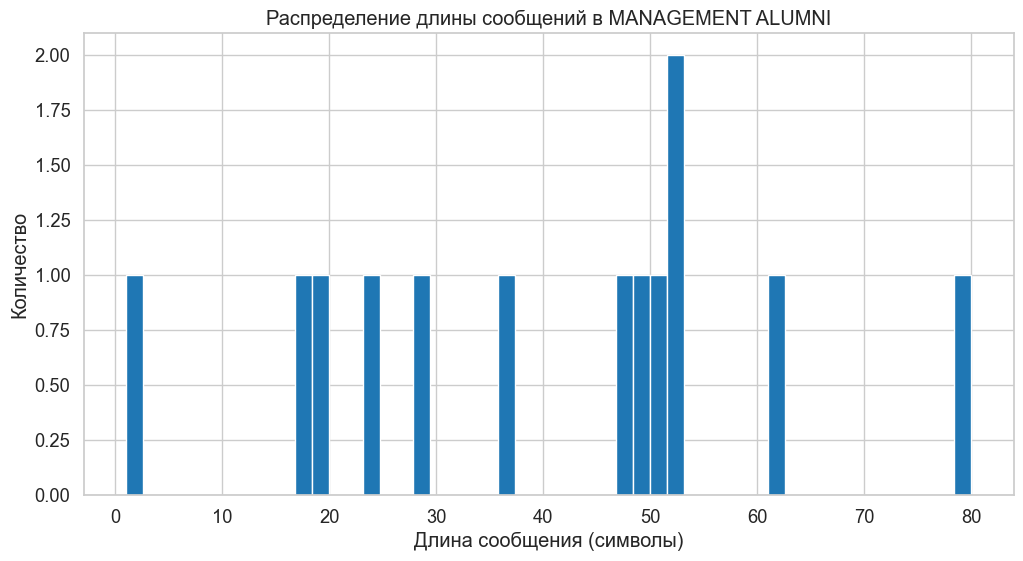

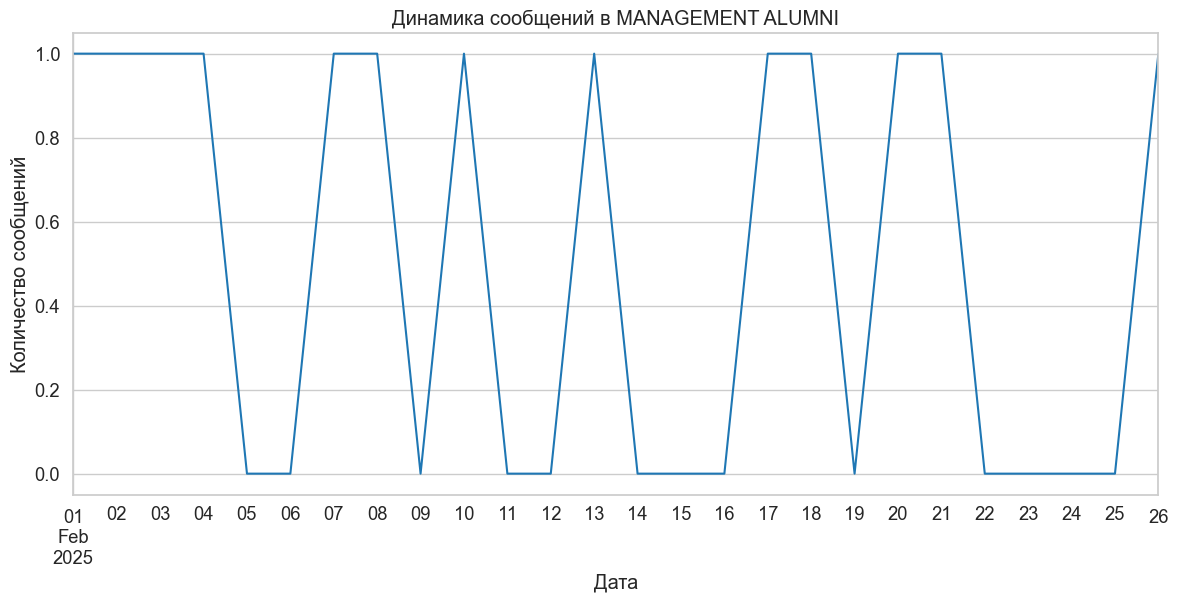

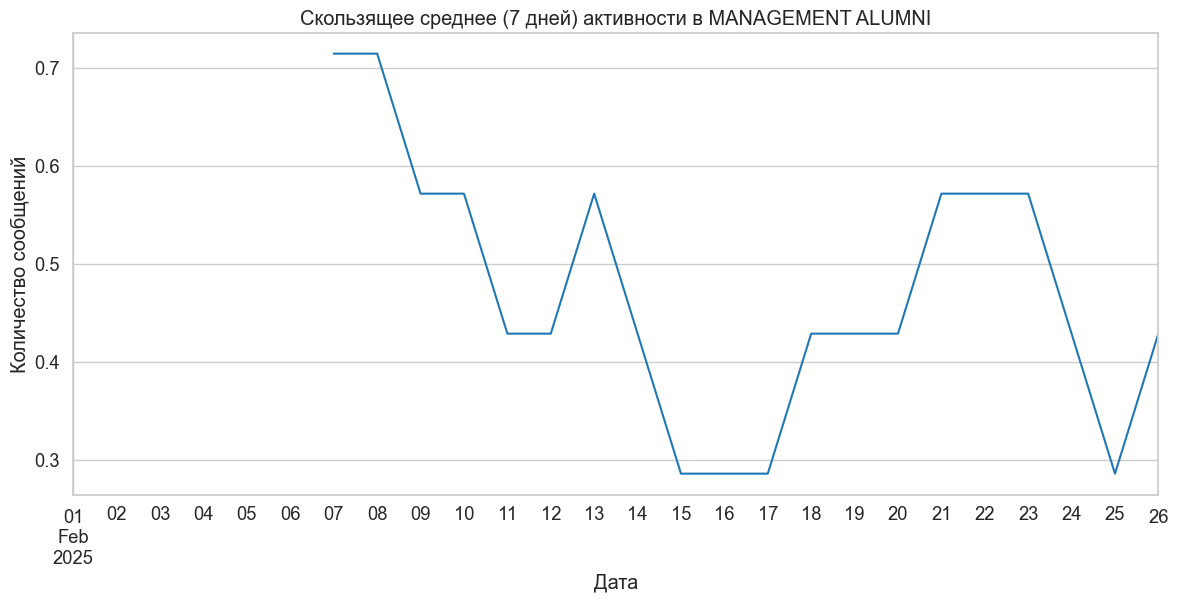


Дополнительный анализ DATA PRACTICUM:
Средняя длина сообщения: 59.6 символов


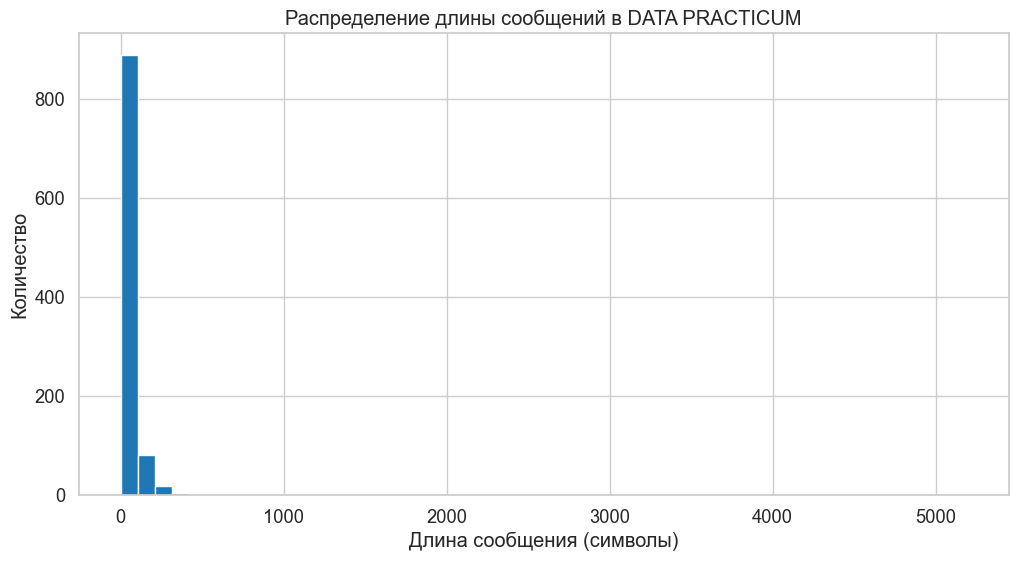

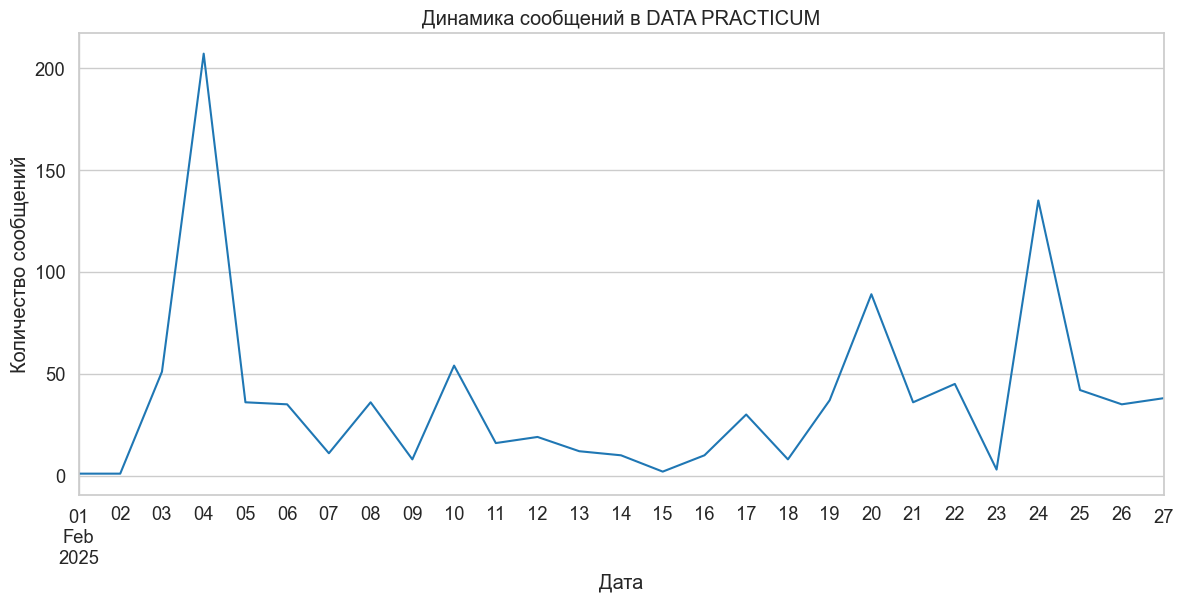

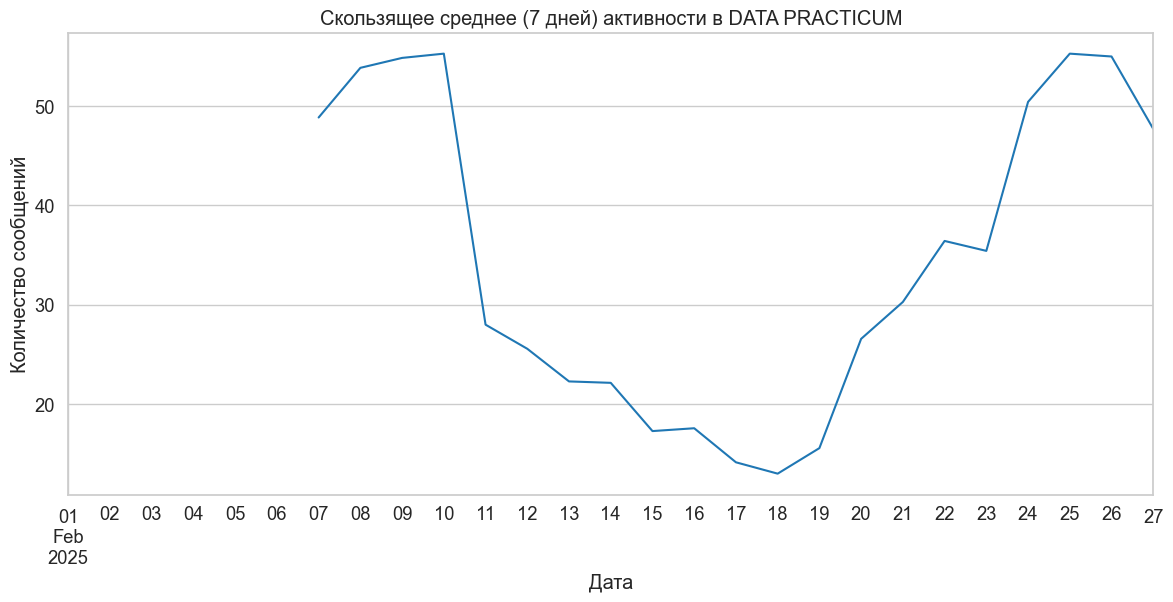


Дополнительный анализ MARKETING CHAT:
Средняя длина сообщения: 75.6 символов


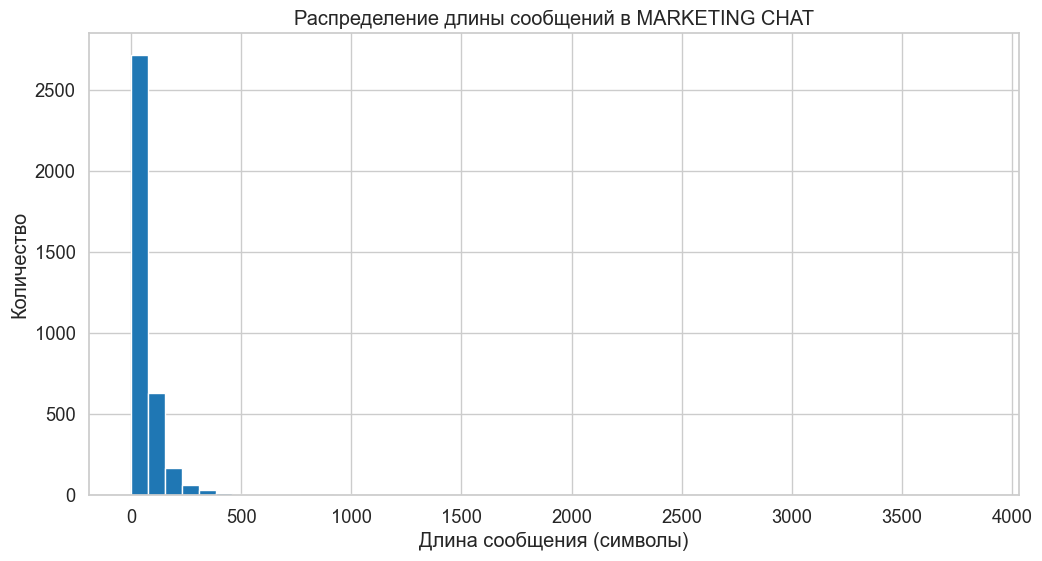

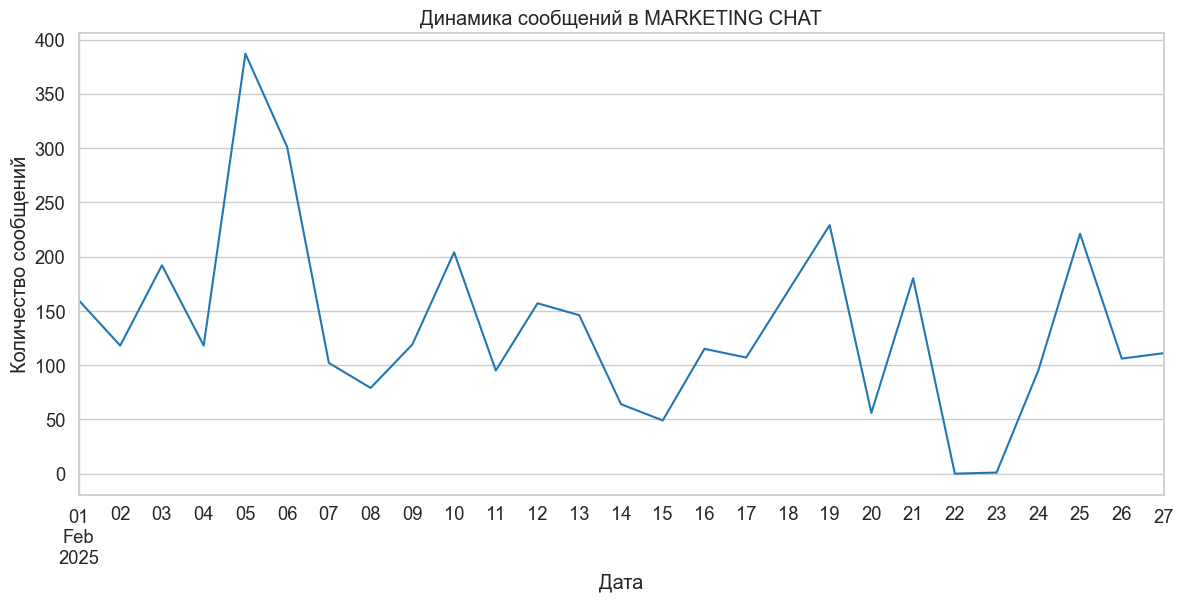

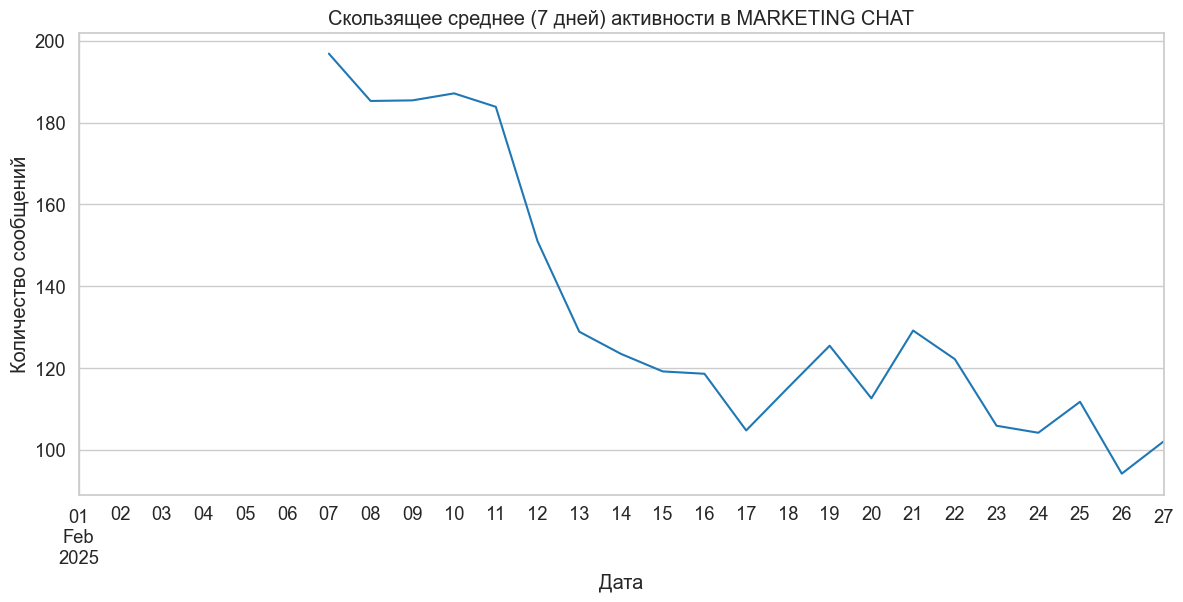

In [91]:

def additional_analysis(df, chat_name):
    """Дополнительные метрики"""
    print(f"\nДополнительный анализ {chat_name}:")
    
    # Средняя длина сообщения
    if 'text_clean' in df.columns:
        df['msg_length'] = df['text_clean'].str.len()
        avg_length = df['msg_length'].mean()
        print(f"Средняя длина сообщения: {avg_length:.1f} символов")
        
        plt.figure(figsize=(12, 6))
        df['msg_length'].hist(bins=50)
        plt.title(f'Распределение длины сообщений в {chat_name}')
        plt.xlabel('Длина сообщения (символы)')
        plt.ylabel('Количество')
        plt.show()
    
    # Динамика сообщений по времени
    if 'date' in df.columns:
        daily_counts = df.resample('D', on='date').size()
        
        plt.figure(figsize=(14, 6))
        daily_counts.plot()
        plt.title(f'Динамика сообщений в {chat_name}')
        plt.xlabel('Дата')
        plt.ylabel('Количество сообщений')
        plt.grid(True)
        plt.show()
        
        # Скользящее среднее для сглаживания
        rolling_avg = daily_counts.rolling(window=7).mean()
        
        plt.figure(figsize=(14, 6))
        rolling_avg.plot()
        plt.title(f'Скользящее среднее (7 дней) активности в {chat_name}')
        plt.xlabel('Дата')
        plt.ylabel('Количество сообщений')
        plt.grid(True)
        plt.show()

print("\n" + "="*50)
print("ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ")
print("="*50)

additional_analysis(manage_alumin, "MANAGEMENT ALUMNI")
additional_analysis(data_practicum, "DATA PRACTICUM")
additional_analysis(marketing_chat, "MARKETING CHAT")

# ==============================================
# БЛОК 7: СРАВНИТЕЛЬНЫЙ АНАЛИЗ ЧАТОВ
# ==============================================

In [92]:

def compare_chats():
    """Сравнительный анализ всех чатов"""
    comparison = []
    
    # Собираем данные по всем чатам
    chats = {
        "MANAGEMENT ALUMNI": {
            'active_users': active_users_manage,
            'time_patterns': time_patterns_manage,
            'text_analysis': text_analysis_manage
        },
        "DATA PRACTICUM": {
            'active_users': active_users_data,
            'time_patterns': time_patterns_data,
            'text_analysis': text_analysis_data
        },
        "MARKETING CHAT": {
            'active_users': active_users_marketing,
            'time_patterns': time_patterns_marketing,
            'text_analysis': text_analysis_marketing
        }
    }
    
    for chat_name, results in chats.items():
        row = {
            'chat': chat_name,
            'total_messages': results['active_users'].sum(),
            'active_users': len(results['active_users']),
            'top_user': results['active_users'].index[0],
            'top_user_msgs': results['active_users'].iloc[0],
            'peak_hour': results['time_patterns']['hourly_activity'].idxmax(),
            'peak_day': results['time_patterns']['daily_activity'].idxmax()
        }
        
        if results['text_analysis']:
            row['top_word'] = results['text_analysis'][0][0]
            row['top_word_count'] = results['text_analysis'][0][1]
        
        comparison.append(row)
    
    return pd.DataFrame(comparison)

print("\n" + "="*50)
print("СРАВНИТЕЛЬНЫЙ АНАЛИЗ ЧАТОВ")
print("="*50)

comparison_df = compare_chats()
print("\nСравнительная статистика чатов:")
print(comparison_df)

# Сохранение результатов
comparison_df.to_excel('chat_comparison.xlsx', index=False)
print("\nРезультаты сохранены в chat_comparison.xlsx")


СРАВНИТЕЛЬНЫЙ АНАЛИЗ ЧАТОВ

Сравнительная статистика чатов:
                chat  total_messages  active_users  \
0  MANAGEMENT ALUMNI              13             1   
1     DATA PRACTICUM             702            20   
2     MARKETING CHAT            3425            20   

                      top_user  top_user_msgs  peak_hour   peak_day  \
0  MANAGEMENT ALUMNI PRACTICUM             13         14     Monday   
1                        Irina             89         12    Tuesday   
2              Андрей Дамаскин            614         17  Wednesday   

     top_word  top_word_count  
0  практикума               2  
1     спасибо              49  
2      только             132  

Результаты сохранены в chat_comparison.xlsx
